In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
# Verify GPU is recognized
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)

Num GPUs Available:  1
TensorFlow version: 2.18.0


In [3]:
import os
import cv2
import numpy as np
from PIL import Image
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

def patchify(image, patch_shape, step):
    patches = []
    img_height, img_width = image.shape[:2]
    patch_height, patch_width = patch_shape[:2]

    if len(image.shape) == 3:
        img_channels = image.shape[2]
        patch_channels = patch_shape[2]
        assert img_channels == patch_channels, "Image and patch channels must match"
    else:
        img_channels = 1
        patch_channels = 1

    for i in range(0, img_height - patch_height + 1, step):
        for j in range(0, img_width - patch_width + 1, step):
            if img_channels == 1:
                patch = image[i:i + patch_height, j:j + patch_width]
            else:
                patch = image[i:i + patch_height, j:j + patch_width, :]
            patches.append(patch)

    patches = np.array(patches)

    if img_channels == 1:
        patches = patches.reshape(-1, patch_height, patch_width)
    else:
        patches = patches.reshape(-1, patch_height, patch_width, patch_channels)

    return patches

root_dir = '/content/drive/MyDrive/Projects/Image_Segmentation/Datasets'
patch_size = 256

image_datasets = []
mask_datasets = []

for path, subdir, files in os.walk(root_dir):
    dir_name = path.split(os.path.sep)[-1]

    if dir_name == 'images':
        images = sorted(os.listdir(path))
        masks_path = path.replace('images', 'masks')
        masks = sorted(os.listdir(masks_path))

        for image_name, mask_name in zip(images, masks):
            if image_name.endswith('jpg') and mask_name.endswith('png'):
                image = cv2.imread(os.path.join(path, image_name), 1)
                mask = cv2.imread(os.path.join(masks_path, mask_name), 1)
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

                Size_X = (image.shape[1] // patch_size) * patch_size
                Size_Y = (image.shape[0] // patch_size) * patch_size

                image = Image.fromarray(image)
                image = image.crop((0, 0, Size_X, Size_Y))
                image = np.array(image)

                mask = Image.fromarray(mask)
                mask = mask.crop((0, 0, Size_X, Size_Y))
                mask = np.array(mask)

                print('Creating patches for image and mask: ', image_name, mask_name)
                patched_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
                patched_mask = patchify(mask, (patch_size, patch_size), step=patch_size)

                for i in range(patched_img.shape[0]):
                    single_patch_img = patched_img[i]
                    single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                    image_datasets.append(single_patch_img)

                    single_patch_mask = patched_mask[i]
                    mask_datasets.append(single_patch_mask)

image_datasets = np.array(image_datasets)
mask_datasets = np.array(mask_datasets)

print(f'Total image patches: {image_datasets.shape[0]}')
print(f'Total mask patches: {mask_datasets.shape[0]}')

Creating patches for image and mask:  image_part_001.jpg image_part_001.png
Creating patches for image and mask:  image_part_002.jpg image_part_002.png
Creating patches for image and mask:  image_part_003.jpg image_part_003.png
Creating patches for image and mask:  image_part_004.jpg image_part_004.png
Creating patches for image and mask:  image_part_005.jpg image_part_005.png
Creating patches for image and mask:  image_part_006.jpg image_part_006.png
Creating patches for image and mask:  image_part_007.jpg image_part_007.png
Creating patches for image and mask:  image_part_008.jpg image_part_008.png
Creating patches for image and mask:  image_part_009.jpg image_part_009.png
Creating patches for image and mask:  image_part_001.jpg image_part_001.png
Creating patches for image and mask:  image_part_002.jpg image_part_002.png
Creating patches for image and mask:  image_part_003.jpg image_part_003.png
Creating patches for image and mask:  image_part_004.jpg image_part_004.png
Creating pat

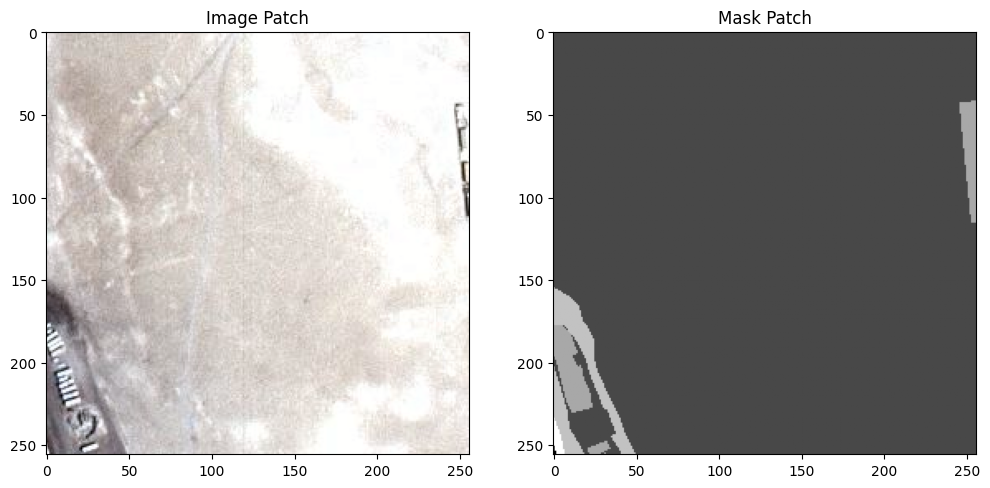

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Sanity check, view few images
image_number = random.randint(0, len(image_datasets) - 1)
plt.figure(figsize=(12, 6))

# Display the image patch
plt.subplot(121)
plt.imshow(np.reshape(image_datasets[image_number], (patch_size, patch_size, 3)))
plt.title('Image Patch')

# Display the mask patch
plt.subplot(122)
plt.imshow(np.reshape(mask_datasets[image_number], (patch_size, patch_size)), cmap='gray')
plt.title('Mask Patch')

plt.show()

In [5]:
def rgb_to_2D_label(label):
    # Initialize output array
    label_seg = np.zeros_like(label, dtype=np.uint8)

    # Map the actual values found in masks to class labels
    label_seg[label == 45] = 0   # Building
    label_seg[label == 92] = 1   # Land
    label_seg[label == 155] = 2  # Road
    label_seg[label == 171] = 3  # Vegetation
    label_seg[label == 172] = 4  # Water

    # Print unique values for verification
    print("Unique values in output segmentation:", np.unique(label_seg))

    return label_seg

# Convert masks to labels
labels = []
for i in range(mask_datasets.shape[0]):
    single_patch_mask = mask_datasets[i]
    label = rgb_to_2D_label(single_patch_mask)
    labels.append(label)

# Convert to numpy array
labels = np.array(labels)



Unique values in output segmentation: [0 1 2 3 4]
Unique values in output segmentation: [1 2 3 4]
Unique values in output segmentation: [0 1 2 3 4]
Unique values in output segmentation: [1 3 4]
Unique values in output segmentation: [1 3 4]
Unique values in output segmentation: [1 4]
Unique values in output segmentation: [1 3 4]
Unique values in output segmentation: [1 3 4]
Unique values in output segmentation: [1 3 4]
Unique values in output segmentation: [1 3 4]
Unique values in output segmentation: [1 3 4]
Unique values in output segmentation: [1 2 3 4]
Unique values in output segmentation: [1 2 3 4]
Unique values in output segmentation: [0 1 4]
Unique values in output segmentation: [0 1 4]
Unique values in output segmentation: [1 3 4]
Unique values in output segmentation: [1 3 4]
Unique values in output segmentation: [0 1 4]
Unique values in output segmentation: [0 1 2 4]
Unique values in output segmentation: [0 1 2 3 4]
Unique values in output segmentation: [1 2 4]
Unique values in

Labels array shape: (1305, 256, 256)
Unique labels in complete dataset: [0 1 2 3 4]


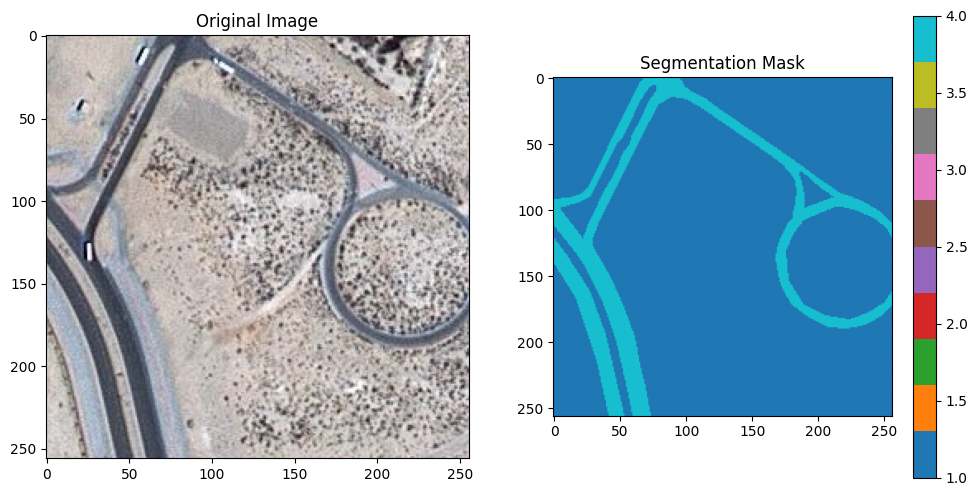

In [6]:
# Verify the results
print("Labels array shape:", labels.shape)
print("Unique labels in complete dataset:", np.unique(labels))

# Visualize a random example
image_number = random.randint(0, len(image_datasets))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_datasets[image_number])
plt.title('Original Image')
plt.subplot(122)
plt.imshow(labels[image_number], cmap='tab10')
plt.title('Segmentation Mask')
plt.colorbar()
plt.show()

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate

def build_unet_model(input_shape=(256, 256, 3), n_classes=5):
    inputs = Input(input_shape)

    # Encoder path (with reduced filters)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)  # Reduced from 64
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)  # Reduced from 128
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)  # Reduced from 256
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    drop3 = Dropout(0.3)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)

    # Bridge
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)  # Reduced from 512
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.3)(conv4)

    # Decoder path
    up5 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(drop4)
    concat5 = concatenate([up5, drop3])
    conv5 = Conv2D(128, 3, activation='relu', padding='same')(concat5)
    conv5 = Conv2D(128, 3, activation='relu', padding='same')(conv5)

    up6 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv5)
    concat6 = concatenate([up6, conv2])
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(concat6)
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv6)
    concat7 = concatenate([up7, conv1])
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(concat7)
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(conv7)

    outputs = Conv2D(n_classes, 1, activation='softmax')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    return model


Epoch 1/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 63s 81ms/step - accuracy: 0.5727 - loss: 1.0853 - val_accuracy: 0.7479 - val_loss: 0.7093
Epoch 2/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.7733 - loss: 0.6674 - val_accuracy: 0.7794 - val_loss: 0.6098
Epoch 3/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.7783 - loss: 0.6592 - val_accuracy: 0.7883 - val_loss: 0.6233
Epoch 4/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.7780 - loss: 0.6391 - val_accuracy: 0.7929 - val_loss: 0.5989
Epoch 5/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.7803 - loss: 0.6297 - val_accuracy: 0.7917 - val_loss: 0.5595
Epoch 6/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.7927 - loss: 0.5968 - val_accuracy: 0.7524 - val_loss: 0.6471
Epoch 7/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.7970 - loss: 0.6119 - val_accuracy: 0.8299 - val_loss: 0.4975
Epoch 8/100
522/522 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.8168 - loss: 0

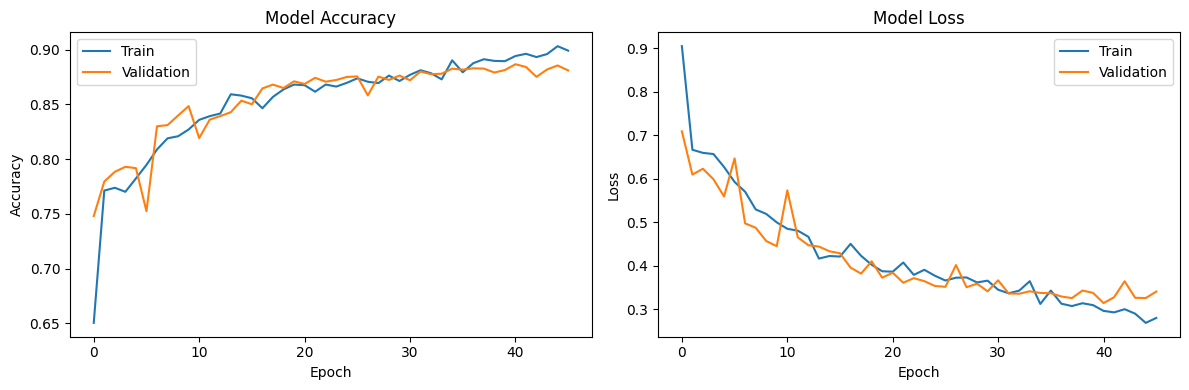

In [9]:
# 1. First, split your existing data
from sklearn.model_selection import train_test_split

# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(
    image_datasets,  # Your image data
    labels,         # Your label data
    test_size=0.2,
    random_state=42
)

# 2. Convert labels to categorical
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=5)

# 3. Now set up training parameters
BATCH_SIZE = 2
EPOCHS = 100

# 4. Create the model
model = build_unet_model(input_shape=(256, 256, 3), n_classes=5)

# 5. Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 6. Set up callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
]

# 7. Calculate steps per epoch
STEPS_PER_EPOCH = len(X_train) // BATCH_SIZE

# 8. Create generator function
def batch_generator(X, y, batch_size):
    while True:
        idx = np.random.randint(0, len(X), batch_size)
        yield X[idx], y[idx]

# 9. Train the model
try:
    history = model.fit(
        batch_generator(X_train, y_train_cat, BATCH_SIZE),
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=EPOCHS,
        validation_data=(X_test, y_test_cat),
        callbacks=callbacks,
        verbose=1
    )
except Exception as e:
    print(f"Training error: {str(e)}")

# 10. Clear session after training
tf.keras.backend.clear_session()

# 11. Plot training history if successful
if 'history' in locals():
    plt.figure(figsize=(12, 4))

    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

In [24]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


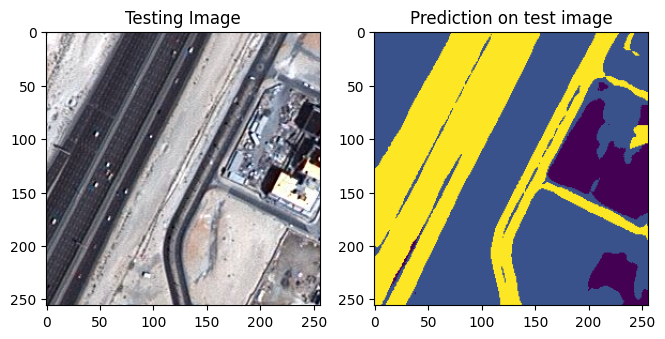

In [38]:
#Predict on a few images

import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()
